## ML models

This notebook trains the following ML models:

1. Logistic Regressor
2. Decision Tree
3. Support-Vector Machine
4. K-Nearest Neighbours
5. Random Forests

as well as two boosting methods:

1. Extreme Gradient Boosting Machine
2. Light Gradient Boosting Machine

In [1]:
from loguru import logger
import time
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
%matplotlib inline

from pygam import LogisticGAM
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import (LGBMClassifier as lgb)
from xgboost import XGBClassifier as xgb

from sklearn.utils import shuffle
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
log_dir = '../../../logs'
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

In [3]:
def get_data(name:str='', SHUFFLE_FLAG:bool=False, NORM_FLAG:bool=True, random_state:int=42):
    '''
    Function to select data

    Arguments
    ---------
    name: str, (required)
        name of dataset to be returned
    SHUFFLE_FLAG: bool, (optional)
        Flag for if the data should be shuffled
    NORM_FLAG: bool, (optional)
        If the data should be normalized
    random_state: int, (optional)
        random_state
    
    Returns
    -------
    X: numpy.ndarray 
        training set 
    y: numpy.ndarray 
        test set
    '''
    
    if name is None or name not in ['gaia']:
        raise ValueError("Required argument 'name' is missing.")
    
    if name == "gaia":
        dir = '../../../data/Gaia DR3/train.parquet'
        data = pd.read_parquet(dir)
        if SHUFFLE_FLAG:
            df = shuffle(data)
        else:
            df = data
        X = np.vstack(df['flux'])
        y = np.vstack(df['Cat'])
        
        y = np.where(y == 'M', 1, y)
        y = np.where(y == 'LM', 0, y)

        y = y.astype(int)

        if NORM_FLAG:
            norm = np.linalg.norm(X,keepdims=True)
            X = X/norm
            
    return X, y

In [4]:
def train_model(model, X, y):
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    st = time.time()
    for train_idx, test_idx in kfold.split(X, y):

        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(x_train, y_train.squeeze(1))
        
        y_pred = model.predict(x_test)
        y_probs = model.predict_proba(x_test)[:,1]
        
        # scoring metrics
        ra_score = roc_auc_score(y_test.squeeze(1), y_probs)
        precision = precision_score(y_test.squeeze(1), y_pred, zero_division=1)
        recall = recall_score(y_test.squeeze(1), y_pred)
        f1 = f1_score(y_test.squeeze(1), y_pred)

        roc_auc_scores.append(ra_score)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    print("ROC-AUC score:",np.mean(roc_auc_scores))
    print("Precision:",np.mean(precision_scores))
    print("Recall:",np.mean(recall_scores))
    print("F1 score:",np.mean(f1_scores))


    log_file = os.path.join(log_dir, f'train_{model.__class__.__name__}.log')
    logger.add(log_file, format="{time} - {level} - {message}")
    logger.info(f"Cross-validation technique:{kfold.__class__.__name__},\
                Number of repeats:{kfold.__dict__['n_repeats']},\
                Number of splits:{kfold.__dict__['cvargs']['n_splits']},\
                Time taken:{time.time()-st},\
                ROC-AUC scores:{roc_auc_scores},\
                Mean ROC-AUC score:{np.mean(roc_auc_scores)},\
                Precision:{precision_scores},\
                Mean precision:{np.mean(precision_scores)},\
                Recall:{recall_scores},\
                Mean recall:{np.mean(recall_scores)},\
                F1 scores:{f1_scores},\
                Mean F1 scores:{np.mean(f1_scores)}")
    return

Total number of spectra: 14101
Number of bins in each spectra: 343
In the dataset, we have 8820 spectra for low mass stars and 5281 spectra for high mass stars.


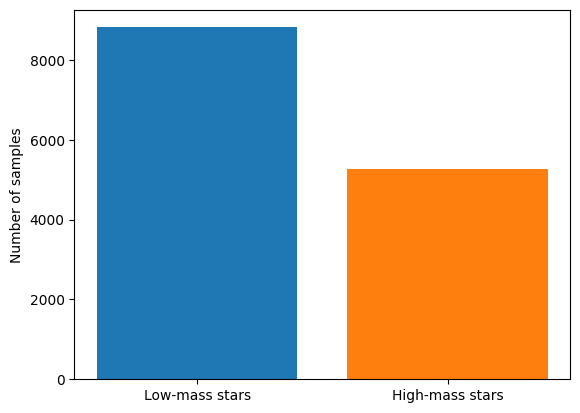

In [5]:
X, y = get_data('gaia', SHUFFLE_FLAG=True)
#X, y = get_data('apogee')

num_samples = X.shape[0]
spectrum_width = X.shape[1]

num_samples_m = np.count_nonzero(y)
num_samples_lm = len(y) - num_samples_m
num_classes = len(np.unique(y))

print("Total number of spectra:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

plt.bar(["Low-mass stars", "High-mass stars"],[num_samples_lm, num_samples_m], color=['#1f77b4', '#ff7f0e'])
plt.ylabel("Number of samples")
plt.show()

In [36]:
#naive splitting methods, not used in this notebook

split = 0.8

train_size = int(split * num_samples)

x_train, x_test = np.split(X, [train_size])
y_train, y_test = np.split(y, [train_size])

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Generalized Additive Model

In [ ]:
model = LogisticGAM()
train_model(model, X, y)

## Logistic Regression

In [6]:
model = LogisticRegression()
train_model(model, X, y)

2024-05-19 10:24:22.492 | INFO     | __main__:train_model:37 - Cross-validation technique:RepeatedStratifiedKFold,                Number of repeats:2,                Number of splits:5,                Time taken:0.7112178802490234,                ROC-AUC scores:[0.9407867215003314, 0.9517431972789115, 0.9466717558235416, 0.95157141139284, 0.9390090316429602, 0.9490128438634994, 0.9404160654160654, 0.9479912861609291, 0.9479757180650038, 0.9444857804232804],                Mean ROC-AUC score:0.9459663811567364,                Precision:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],                Mean precision:1.0,                Recall:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],                Mean recall:0.0,                F1 scores:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],                Mean F1 scores:0.0


ROC-AUC score: 0.9459663811567364
Precision: 1.0
Recall: 0.0
F1 score: 0.0


## Decision Trees

In [7]:
model = DecisionTreeClassifier()
train_model(model, X, y)

2024-05-19 10:28:44.609 | INFO     | __main__:train_model:37 - Cross-validation technique:RepeatedStratifiedKFold,                Number of repeats:2,                Number of splits:5,                Time taken:260.4743993282318,                ROC-AUC scores:[0.8822749535007948, 0.8824528233010376, 0.9005026884491171, 0.8944424044870475, 0.8931639417130489, 0.89153939721584, 0.876678670205456, 0.8834910542499829, 0.8921557732941663, 0.8867713594276093],                Mean ROC-AUC score:0.8883473065844101,                Precision:[0.9010566762728146, 0.9083011583011583, 0.916030534351145, 0.9161041465766635, 0.9164237123420796, 0.9236043095004897, 0.9115913555992141, 0.9167482859941234, 0.9142581888246628, 0.9076034648700674],                Mean precision:0.9131721832632419,                Recall:[0.8874172185430463, 0.8910984848484849, 0.9090909090909091, 0.8996212121212122, 0.8929924242424242, 0.8921475875118259, 0.8787878787878788, 0.8863636363636364, 0.8986742424242424, 0.89299

ROC-AUC score: 0.8883473065844101
Precision: 0.9131721832632419
Recall: 0.8929186018176084
F1 score: 0.9029124695903761


## Random Forest

In [8]:
model = RandomForestClassifier()
train_model(model, X, y)

2024-05-19 10:35:51.014 | INFO     | __main__:train_model:37 - Cross-validation technique:RepeatedStratifiedKFold,                Number of repeats:2,                Number of splits:5,                Time taken:426.37098360061646,                ROC-AUC scores:[0.974237992264077, 0.9807640069916855, 0.9818033116024186, 0.9806373149007078, 0.9775800629595274, 0.9807701383927901, 0.9776758872741015, 0.9779783914828557, 0.9788110161994091, 0.9763469623960694],                Mean ROC-AUC score:0.9786605084463641,                Precision:[0.9204440333024977, 0.9211242067089755, 0.9400749063670412, 0.9246511627906977, 0.9299065420560748, 0.9409559512652296, 0.9175824175824175, 0.9269870609981515, 0.9351251158480074, 0.9215143120960295],                Mean precision:0.9278365709015122,                Recall:[0.9413434247871334, 0.9621212121212122, 0.9507575757575758, 0.9412878787878788, 0.9422348484848485, 0.9498580889309366, 0.9488636363636364, 0.9498106060606061, 0.9554924242424242, 0.9

ROC-AUC score: 0.9786605084463641
Precision: 0.9278365709015122
Recall: 0.9486845453112009
F1 score: 0.9381216826264455


## K-Nearest Neighbours

In [14]:
model = KNeighborsClassifier()
train_model(model, X, y)

pickle.dump(model, open('../../trained_models/knn-classification.pickle', 'wb'))

2024-05-19 12:12:32.086 | INFO     | __main__:train_model:37 - Cross-validation technique:RepeatedStratifiedKFold,                Number of repeats:2,                Number of splits:5,                Time taken:6.121830463409424,                ROC-AUC scores:[0.9786894732664431, 0.9780454953446024, 0.9824767659589089, 0.9796017681062323, 0.9832930173331957, 0.9847247161242296, 0.9801912084278155, 0.9764884173366316, 0.9829266302480587, 0.9790864104480176],                Mean ROC-AUC score:0.9805523902594135,                Precision:[0.9162162162162162, 0.9148745519713262, 0.9356025758969642, 0.9182561307901907, 0.9091726618705036, 0.9339449541284404, 0.9133154602323503, 0.9234317343173432, 0.9236430542778289, 0.906832298136646],                Mean precision:0.919528963783781,                Recall:[0.9621570482497634, 0.9668560606060606, 0.9630681818181818, 0.9573863636363636, 0.9573863636363636, 0.9631031220435194, 0.9678030303030303, 0.9479166666666666, 0.9507575757575758, 0.967

ROC-AUC score: 0.9805523902594135
Precision: 0.919528963783781
Recall: 0.9604237443020555
F1 score: 0.9394893224542592


## Light Gradient Boosting Machine

In [10]:
model = lgb(verbosity=-1)
train_model(model, X, y)

2024-05-19 10:36:14.165 | INFO     | __main__:train_model:37 - Cross-validation technique:RepeatedStratifiedKFold,                Number of repeats:2,                Number of splits:5,                Time taken:16.640986919403076,                ROC-AUC scores:[0.9836300808560573, 0.9880224975091046, 0.989117900948258, 0.9887238670720814, 0.9894123526936027, 0.990935336607049, 0.9858072648251219, 0.9851338104686319, 0.9900243399127328, 0.9856325263691336],                Mean ROC-AUC score:0.9876439977261773,                Precision:[0.9121561668145519, 0.9204647006255585, 0.9291553133514986, 0.927007299270073, 0.91971454058876, 0.9360730593607306, 0.9159964253798034, 0.919602529358627, 0.9257246376811594, 0.91005291005291],                Mean precision:0.9215947582483672,                Recall:[0.9725638599810785, 0.9753787878787878, 0.96875, 0.9621212121212122, 0.9763257575757576, 0.9697256385998108, 0.9706439393939394, 0.9640151515151515, 0.9678030303030303, 0.9772727272727273], 

ROC-AUC score: 0.9876439977261773
Precision: 0.9215947582483672
Recall: 0.9704600104641494
F1 score: 0.9453649214060779


## Extreme Gradient Boosting Machine

In [11]:
model = xgb()
train_model(model, X, y)

2024-05-19 10:36:46.982 | INFO     | __main__:train_model:37 - Cross-validation technique:RepeatedStratifiedKFold,                Number of repeats:2,                Number of splits:5,                Time taken:32.77541494369507,                ROC-AUC scores:[0.9839942441814316, 0.9866398895416753, 0.9881746890675462, 0.989119779856387, 0.9893600116814403, 0.9903888234574814, 0.9859680456778671, 0.9854526880196522, 0.9898227599120456, 0.984620600133993],                Mean ROC-AUC score:0.987354153152952,                Precision:[0.9194991055456172, 0.9177837354781054, 0.9314442413162706, 0.9286367795059469, 0.9299363057324841, 0.9354838709677419, 0.9171171171171171, 0.9293577981651376, 0.9354545454545454, 0.9082813891362422],                Mean precision:0.9252994888419208,                Recall:[0.9725638599810785, 0.9725378787878788, 0.9649621212121212, 0.9611742424242424, 0.9678030303030303, 0.9602649006622517, 0.9640151515151515, 0.959280303030303, 0.9744318181818182, 0.96590

ROC-AUC score: 0.987354153152952
Precision: 0.9252994888419208
Recall: 0.9662942397006967
F1 score: 0.9453210124654887
